Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Alex Arzamasov"
COLLABORATORS = ""

---

# Homework 6: RNA-Seq and Transformation of Raw Data (Pre-processing) 
Curated by Sabah Ul-Hasan, Karthik Gangavarapu, Shang-Fu Chen, Jerry Zak, and Andrew Su

Complete homework is due every Tuesday at 8 AM PST. <br>
Save your homework as you go, so the efforts don't get lost. <br>
Note there are up 13 points, but you can only receive 10 points total for homework.

## A6.aa: Solidify your understanding of plotting in R [20-30 min] Group of 3 

### Question 1 (1 point)

1. Code review: Take turns briefly talking through your code and process (3-5 min), then spend the remaining time discussing the different approaches you may have taken to get to the same end-goal. Compare the types of visuals you included, and the how behind each of them.
1. For the last 5 minutes on your own, think of a suggestion of something you would've liked to learn in relation to these topics that we didn't cover.

1. NA
2. More `tidyverse` exercises on working with tables (not plotting)

## A6.ab: Familiarizing yourself with the FASTQ format

### Question 2 (2 points)
1. How many paired end and how many single end FASTQs are present in the folder `hw6/data/illumina_files/` ?
1. Count the number of reads in each of the sequenced samples. Consider paired reads to be one sample.

In [1]:
%%bash
cd ./data/illumina_example
ls


for file in *.fastq
do
    cat $file | awk 'NR%4==2' | wc -l
done

SRR12742806_R1.fastq
SRR12742806_R2.fastq
SRR12742806.sam
SRR5454101.1_downsampled.fastq
SRR5454101.1_downsampled_fastqc.html
SRR5454101.1_downsampled_fastqc.zip
118
118
1000


1. One single-end and one paired-end (R1+R2) FASTQ files are present in the folder
2. SRR5454101.1 contains 1000 reads, SRR12742806 contains 236 reads

## A6.ab: Familiarizing yourself with RNA-Seq, and output data [20-30 min] Group of 3
#### ab.ii Familiarizing yourself with raw RNA-Seq data and associated software (on your own time) <br>

### Question 3 (3 points)

1. What is the command to generate fastqc report for the file SRR5454101.1_downsampled?
2. What specific categories were flagged in `orange` or `red` in the report? Give reasons as to why they might have been flagged. Consult the manual for details on each analysis module - https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/
3. Generate a fastqc report for the file `Zymo-GridION-EVEN-BB-SN_downsampled.fastq` present in the folder `hw6/data/nanopore_example/`. Contrast the report you generated here with the one you generated in question 1 by giving two specific quantities/analysis modules in which the two reports differ.

1. `fastqc SRR5454101.1_downsampled.fastq`
2. Categories flagged as orange and red:
   - `Per base sequence content`: red flag caused by non-standard base content in the first (many Ns) and last positions of reads
   - `Per sequence GC content`: the small number of reads in the sample makes the GC content distribution look not perfectly normal
   - `Per base N content`: too many reads have N (unknown nucleotide) in the first position, which means the sequencer could not make a base call for the base in the first position (also can be seen in reduced quality scores of the first position in `Per base sequence quality`)
   - `Sequence Length Distribution`: the reads are relatively short even for Illumina; thus, the distribution is a bit skewed to the left
   - `Overrepresented sequences`: there are some overrepresented sequences; however, since the overall number of reads is tiny, I would say this flag is irrelevant
3. Differences between reports
    - `Per base sequence quality`: overall, quality scores are much lower for Nanopore compared to Illumina, which makes sense since Nanopore sequencing accuracy is also much lower
    - `Sequence Length Distribution`: on the contrary, you can see that Nanopore reads compared to Illumina ones are: (1) much longer (> 1000 vs. 50), (b) significantly vary in length (vs. constant 50)

## A6.ba: Processing alignments [20-30 min] TPS

### Question 4 (4 points)

Use hisat2 to create an index of the ENST00000427411.1.fa fasta file present in the folder `hw6/data/ref/`. Now, use hisat2 to align the paired reads from the sample SRR12742806, located at `hw6/data/illumina_example/`, to the reference you created in the previous step.

1. How many reads mapped to the genome?
2. What is the size of the SAM file and the size of the BAM file? 
3. Generate a plot of the average depth per position of this alignment.
4. What percentage of the reference genome is covered by the sequenced reads in this alignment? 

118 reads; of these:
  118 (100.00%) were paired; of these:
    26 (22.03%) aligned concordantly 0 times
    80 (67.80%) aligned concordantly exactly 1 time
    12 (10.17%) aligned concordantly >1 times
    ----
    26 pairs aligned concordantly 0 times; of these:
      20 (76.92%) aligned discordantly 1 time
    ----
    6 pairs aligned 0 times concordantly or discordantly; of these:
      12 mates make up the pairs; of these:
        4 (33.33%) aligned 0 times
        6 (50.00%) aligned exactly 1 time
        2 (16.67%) aligned >1 times
98.31% overall alignment rate

1. 232 out of 236 reads mapped
2. 72 kb for the SAM file, 14 kb for the BAM file
3. 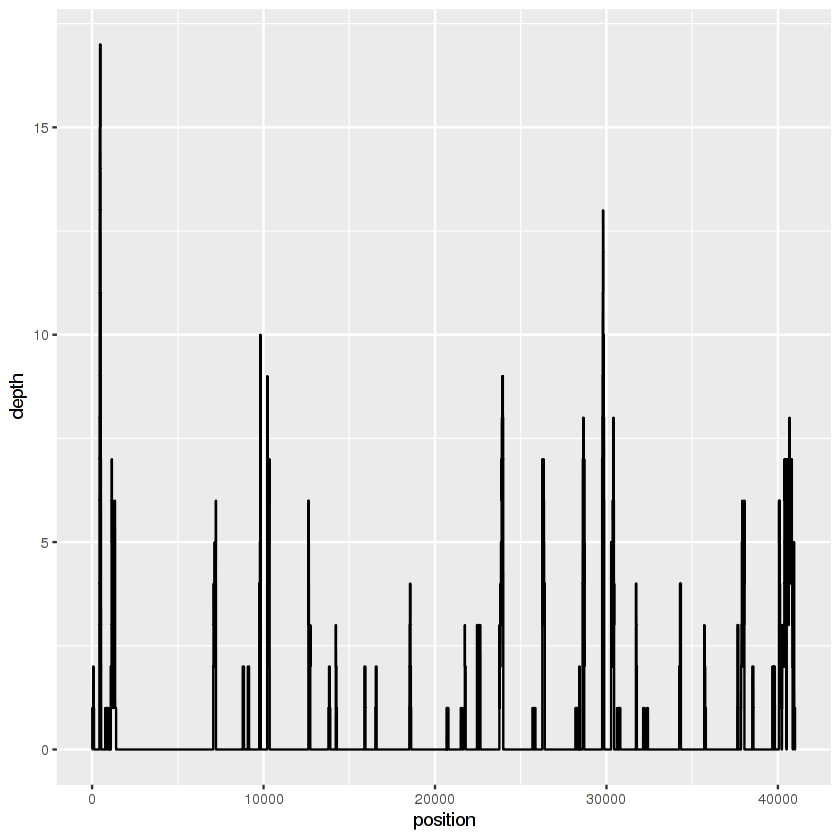
4. 12.9% is covered by at least one read

[1] 12.90543

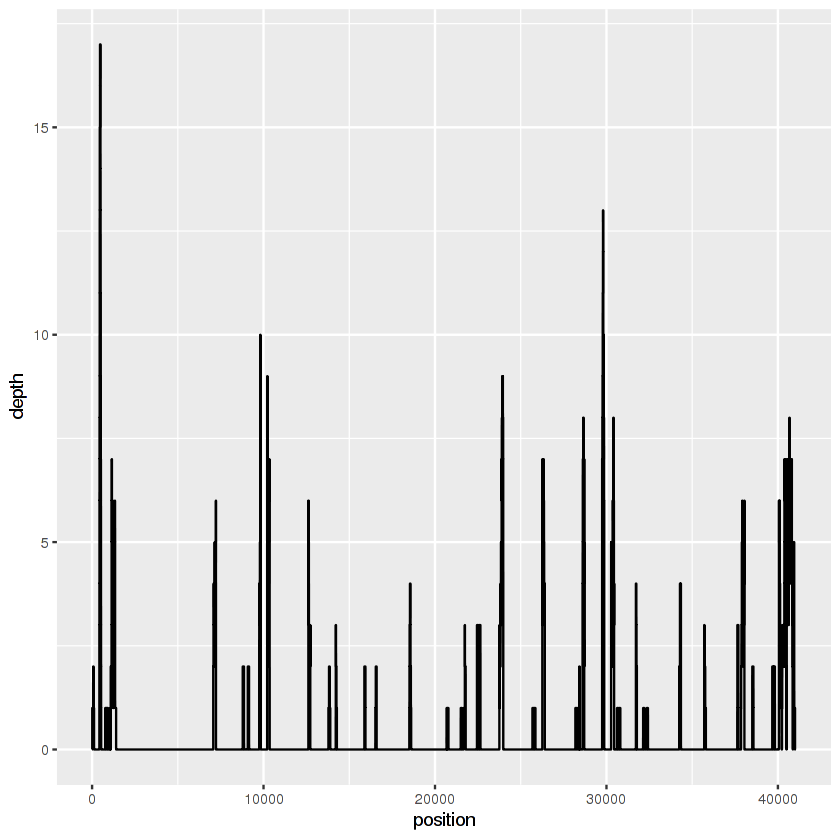

In [13]:
#R code
setwd("./data/illumina_example")
library(tidyverse)

# read the file
alignment_depth <- as_tibble(read.table(file = "depth.txt")) %>% 
    rename("position" = V2) %>% rename("depth" = V3)

# create the plot
ggplot(data = alignment_depth) +
    geom_line(mapping = aes(x = position, y = depth))

#calculate coverage
coverage = (length(subset(alignment_depth, depth != 0)$position) / length(alignment_depth$position)) * 100
coverage

### Question 5 (1 point)

Look up the [samtools manual](https://www.htslib.org/doc/samtools.html) and paste the command that is required to convert BAM files to FASTQ.

`samtools fastq SRR12742806.bam > SRR12742806.fastq`


### Question 6 (2 points)

We've previously seen that it is possible to combine bash commands using a pipe(`|`). Use the pipe to write a one-liner in bash to produce a sorted BAM file starting with the FASTQ files.

`hisat2 -x ../ref/index -1 SRR12742806_R1.fastq -2 SRR12742806_R2.fastq | samtools sort -o SRR12742806_sorted.bam`